In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai import metrics

In [3]:
PATH = os.path.abspath('..')

In [4]:
bs = 16
sz = 32

In [5]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)

In [6]:
df.head()

,objID,oh_p50
0,1237648704043942146,8.882136
1,1237667292122513532,8.951163
2,1237665441525596194,8.823326
3,1237674289683300721,9.104471
4,1237663716556341422,9.014245


# Set up DataBunch object

In [7]:
tfms = get_transforms(do_flip=False)
data = (ImageItemList.from_df(path=PATH, 
                              df=df, 
                              folder='train',
                              cols='objID',
                              suffix='.jpg')
        .random_split_by_pct(0.2)
        .label_from_df(cols='oh_p50', label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [8]:
src = (ImageItemList.from_df(df, path=PATH, folder='train', suffix='.jpg', cols='objID')
                .random_split_by_pct(0.2, seed=1234)
                .label_from_df(cols='oh_p50',  label_cls=FloatList)
      )

In [9]:
data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

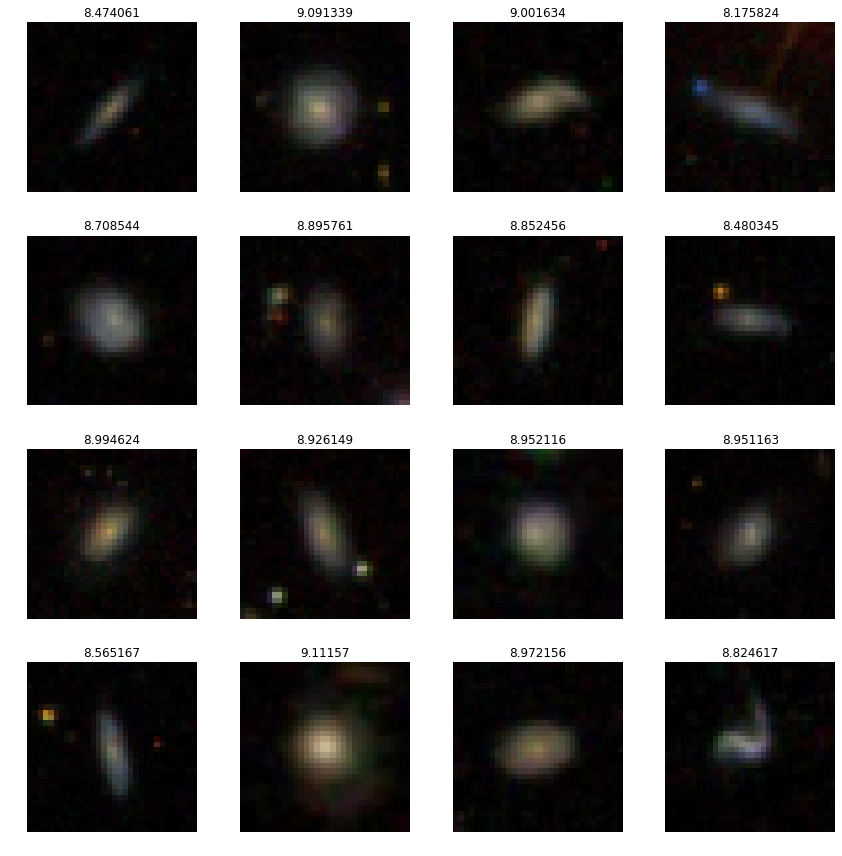

In [10]:
data.show_batch(4, figsize=(12, 12))

# Set up simple convnet

In [11]:
defaults.device = torch.device('cpu')

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                  # pretrained kw is hardcoded into create_cnn
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
learn = create_cnn(data, arch=SimpleCNN, pretrained=False, loss_func=root_mean_squared_error)
#learn = create_cnn(data, arch=models.resnet18, pretrained=False, loss_func=root_mean_squared_error)

# Find learning rate and train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


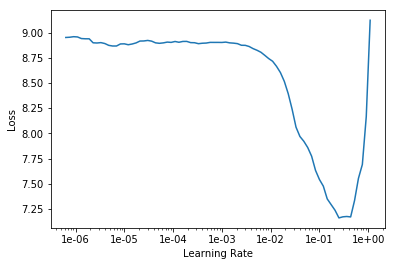

In [14]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(10, slice(1e-3, 1e-1))

epoch,train_loss,valid_loss
1,6.217523,0.926090
2,4.192538,2.602732
3,3.525542,2.749235
4,3.046788,2.720216
5,2.585419,1.487128
6,2.222713,0.881848
7,1.876180,1.051670
8,1.640906,0.386341
9,1.354949,0.204745
10,1.129004,0.177526


In [16]:
learn.fit_one_cycle(10, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss
1,0.697206,0.182278
2,0.707426,0.189238
3,0.686895,0.281364
4,0.668020,0.241949
5,0.635559,0.272291
6,0.632325,0.227270
7,0.617031,0.221098
8,0.592537,0.197905
9,0.554574,0.180806
10,0.540091,0.172336


In [40]:
learn.fit_one_cycle(10, slice(1e-5, 1e-3), pct_start=0.5)

epoch,train_loss,valid_loss
1,0.463724,0.170179
2,0.498792,0.169668
3,0.496035,0.178012
4,0.498990,0.205465
5,0.489973,0.155137
6,0.475973,0.179308
7,0.490512,0.157272
8,0.486426,0.170374
9,0.492537,0.154984
10,0.493223,0.151714


# Results

In [46]:
Z_pred, Z_true = learn.TTA()

In [47]:
root_mean_squared_error(Z_pred, Z_true)

tensor(0.7815)

# Use `resnet18`

In [51]:
learn = create_cnn(data, arch=models.resnet18, pretrained=True, loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


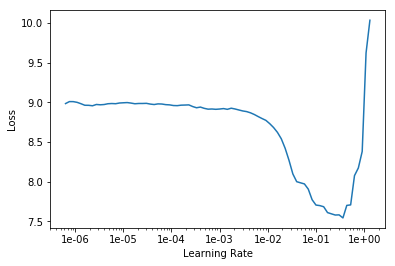

In [49]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(3, slice(3e-3, 3e-2))

epoch,train_loss,valid_loss
1,6.299057,1.552297
2,3.799037,2.129560
3,2.716573,0.906145


In [53]:
learn.fit_one_cycle(3, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss
1,1.392536,0.816574
2,1.338237,0.844110
3,1.280430,0.795562


# Old fitting method

In [54]:
learn = create_cnn(data, arch=models.resnet18, pretrained=True, loss_func=root_mean_squared_error)

In [55]:
learn.fit(epochs=2, lr=0.1)

epoch,train_loss,valid_loss
1,5.323806,2.656692
2,4.213621,2.737528


In [57]:
learn.fit(epochs=4,  lr=1e-2)

epoch,train_loss,valid_loss
1,2.375433,1.471779
2,2.106245,0.604671
3,1.811482,0.897091
4,1.623346,0.553340
